<a href="https://colab.research.google.com/github/ILYAGRISH/ILYAGRISH/blob/main/L08_NN_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a href="https://msu.ai/"><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.3/msu_ai.png" width="1024"></a></center>

<font size="6">Архитектуры CNN</font>

# Базовые компоненты свёрточных сетей



Мы рассмотрели базовые компоненты, из которых состоят современные свёрточные нейронные сети, а также техники их обучения.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/basic_components_cnn.png" width = "1000"></center>


На этом занятии рассмотрим, какие модели можно построить на основе этих компонентов.

# ImageNet

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/imagenet_banner.jpeg"  width="800"></center>

<center><em>Source: <a href="https://cv.gluon.ai/build/examples_datasets/imagenet.html">ImageNet</a></em></center>

ImageNet — одно из самых известных соревнований в области распознавания изображений и машинного зрения (полное название — **ImageNet Large Scale Visual Recognition Challenge (ILSVRC)**, проводилось ежегодно в 2010–2017 годах). Содержит более 14 миллионов вручную размеченных изображений, принадлежащих к 1000 классам.

Для загрузки с [официального сайта 🛠️[doc]](http://image-net.org/download) необходимо запрашивать доступ, но можно загрузить данные с [Kaggle 🛠️[doc]](https://www.kaggle.com/c/imagenet-object-localization-challenge/data). Однако архив занимает порядка 156 Gb и не поместится на диск Colab. Поэтому воспользуемся другим репозиторием, который содержит 1000 изображений из оригинального датасета.

P.S. Для загрузки данных, которые стали недоступны на официальных сайтах, в частности для [ImageNet 🛠️[doc]](https://academictorrents.com/browse.php?search=imagenet), можно использовать [Academic Torrents 🛠️[doc]](https://academictorrents.com).

In [ ]:
import torch
import random
import numpy as np

# fix random_seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# compute in cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Full list of labels
#'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/imagenet_class_index.json

# https://github.com/ajschumacher/imagen.git
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/imagen.zip
!unzip -q imagen.zip

Загрузили категории:

In [ ]:
import json
import pprint
import numpy as np

pp = pprint.PrettyPrinter(width=41, compact=True)

with open("imagenet_class_index.json") as f:
    imagenet_labels = json.load(f)

classes = np.array(list(imagenet_labels.values()))[:, 1]

pp.pprint(
    dict(list(imagenet_labels.items())[:10])
)  # Use Pretty Print to display long dict

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich']}


In [ ]:
from glob import glob
from PIL import Image
from torch.utils.data import Dataset


class MicroImageNet(Dataset):
    def __init__(self):
        super().__init__()
        # Load labels
        self.num2id = {}
        with open("imagenet_class_index.json") as f:
            imagenet_labels = json.load(f)
        w_net = {}
        # Because not all world net image codes from imagen exists in imagenet_labels
        # we need to filter this image
        for key in imagenet_labels.keys():
            wn_id = imagenet_labels[key][0]
            w_net[wn_id] = {"num": int(key), "name": imagenet_labels[key][1]}
        self.labels = []
        self.paths = []

        # Load data
        images = glob("imagen/*.jpg")
        images.sort()
        for i, path in enumerate(images):
            name = path.split("_")[2]  # Class name
            id = path.split("_")[0][7:]  # WorldNet based ID
            if w_net.get(id, None):
                self.labels.append([w_net[id]["num"], w_net[id]["name"], id])
                self.paths.append(path)

    def __getitem__(self, idx):
        im = Image.open(self.paths[idx])
        class_num = self.labels[idx][0]
        return im, class_num

    def __len__(self):
        return len(self.paths)


microImgNet = MicroImageNet()

Посмотрим на картинки:

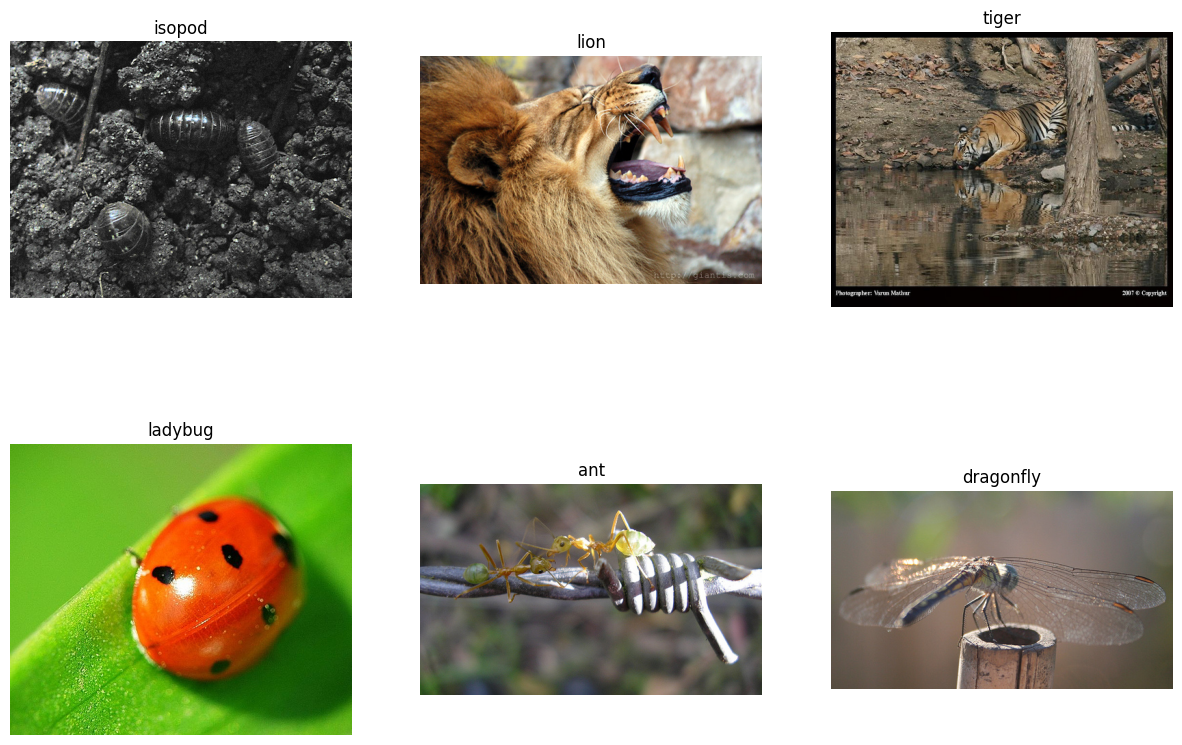

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 10)


def show(img, label_1, num, label_2=""):
    ax = plt.subplot(2, 3, num + 1)
    plt.imshow(img)
    plt.title(label_1)
    ax.set_xlabel(label_2)
    plt.axis("off")


for i in range(6, 12):
    img, label = microImgNet[i * 6]
    name = microImgNet.labels[i * 6][1]
    show(img, name, i - 6)

## Метрики ImageNet

[[doc] 🛠️ ILSVRC](http://image-net.org/challenges/LSVRC/2017/)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/imagenet_large_scale_visual_recognition_challenge.png"  width="900"></center>

<center><em>Лучшие результаты конкурса ILSVRC по годам</em></center>

Особенности разметки:
* На каждом изображении могут быть один или несколько предметов, относящихся к одному из **1000 классов**.
* В соревновании оцениваются 2 метрики: **Тop-5** и **Top-1** (выше график для **Top-5**)
* Для метрики **Тop-5** алгоритм выбирает из предсказания модели 5 классов, имеющих наибольшую вероятность. Если предмет, относящийся к одному из этих классов, есть на изображении, то ответ засчитывается как верный.
* Для **Top-1**, соответственно, выбирается только метка класса с наибольшей вероятностью.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/imagenet1.png" width="700" ></center>

<center><em>Source: <a href="https://image-net.org/">ImageNet</a></em></center>

В 1000 классов ImageNet нет класса люди, но есть одежда, инструменты и 12 пород кошек (каждая порода — отдельный класс).

Подробное описание датасета, классов и правил разметки:
* [[article] 🎓 ImageNet: A large-scale hierarchical image database](https://ieeexplore.ieee.org/document/5206848)

# Baseline (AlexNet 2012)

[[article] 🎓 ImageNet Classification with Deep Convolutional Neural Networks (Krizhevsky et al., 2012)](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

Создана в **University of Toronto**.

Современный бум нейросетевых технологий начался в 2012 году, когда AlexNet с большим отрывом от конкурентов победила в ImageNet.

Архитектура AlexNet состоит из пяти свёрточных слоёв, между которыми располагаются pooling-слои и слои нормализации, а завершают нейросеть три полносвязных слоя.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/alexnet_architecture.png" width="800"></center>

<center><em>Архитектура сети AlexNet</em></center>

[[blog] ✏️ Подробнее про AlexNet](https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide)

Можно заметить, что архитектура AlexNet состоит из **двух работающих параллельно нейросетей**, которые обмениваются информацией после 2-го и 5-го сверточного слоя и в полносвязных слоях. Это было необходимо, т.к. сеть не помещалась на одну видеокарту, и для обучения использовались две **GPU GTX580** с 3 ГБ видеопамяти. На вход нейронной сети подавалось цветное изображение размером $224×224$ пикселя, к которому применялось $96$ фильтров с ядром $11×11×3$ и сдвигом $4$. Веса, первых $48$ фильтров хранились на первой видеокарте, а другие $48$ фильтров были на второй видеокарте.


- **Пространственные размеры** карты признаков быстро сжимаются: $224×224 \to 55×55 \to 27×27 \to 13×13 \to 13×13 \to 13×13$.

- При этом увеличивается **количество сверток** (фильтров) в каждом слое: $96 (48×2) \to 256 (128×2) \to 384 (192×2) \to 256 (128×2)$.

- На выходе нейросети стоят два **полносвязных слоя** на 2048 нейронов и 1000 (в **ImageNet** 1000 классов).

**AlexNet** можно использовать для классификации **CIFAR-10**, но для этого нужно адаптировать архитектуру сети. Применение первых сверточных слоев **AlexNet**, предназначенных для изображений размером $224×224$, к изображениям размером $32×32$ приведет к слишком быстрому уменьшению карты признаков, что сделает невозможное применение фильтров. Можно увеличить изображения до $224×224$, но это требует больших вычислительных ресурсов.


Архитектуры старых сетей, таких как **AlexNet**, обученные на **ImageNet**, были разработаны с учетом фиксированного размера входных изображений. В современных сетях применяется слой [Adaptive Average Pooling 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), который помогает работать с изображениями разных размеров.



Такая архитектура показала прорывную точность: 2 место имело ошибку **26.2%** против **15.3%** у AlexNet.

<center><em><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/alexnet_architecture_with_parameters.png" width="1000"></em></center>
<center><em>Архитектура сети AlexNet c параметрами слоев</em></center>

Нестандартные решения, принятые разработчиками **AlexNet**:
* Использование **ReLU** в качестве функции активации. Предшественники использовали ограниченные функции типа сигмоиды или тангенса, которые приводили к затуханию градиента.
* Использование **Response Normalization**. Позже было показано, что эта нормализация не давала значительного прироста скорости обучения и качества модели. В современных моделях чаще используется Batch-нормализация или Layer-нормализация.
* Использование различных **методов аугментации** входных данных, таких как повороты, увеличение, зашумление и др., для увеличения разнообразия входных данных.
* Использование **Dropout** $=0.5$ (при обучении отключается случайная половина нейронов).
* Использование **SGD Momentum** $=0.9$. Для обеспечения сходимости авторы использовали эвристику для **понижения скорости обучения** (оптимизатор Adam появился только в 2014 году).
* **Скорость обучения** стартует со значения $10^{-2}$ и уменьшается в $10$ раз, когда качество перестает расти.
* **L2-регуляризация** с весом $5 \cdot 10^{-4}$.
* Использование **ансамбля** из $7$ обученных из различного начального состояния моделей. Результат работы моделей усредняется. Данное решение увеличило точность с $81.8\%$ до $84.7\%$.


Сравним реализацию в PyTorch с оригинальной. В чем отличия?

In [ ]:
from torchvision import models

alexnet = models.alexnet(weights="AlexNet_Weights.DEFAULT")

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 139MB/s]


In [ ]:
from torchsummary import summary

print("AlexNet architecture")
print(summary(alexnet, (3, 224, 224), device="cpu"))
print(alexnet)

AlexNet architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-

В PyTorch версии:
- отсутствуют нормализации,
- отсутствует разделение на две видеокарты,
- немного изменено количество сверток на некоторых слоях,
- добавлен слой Adaptive Average Pooling.

Количество слоев и размеры сверток те же.

Проверим, как работает:

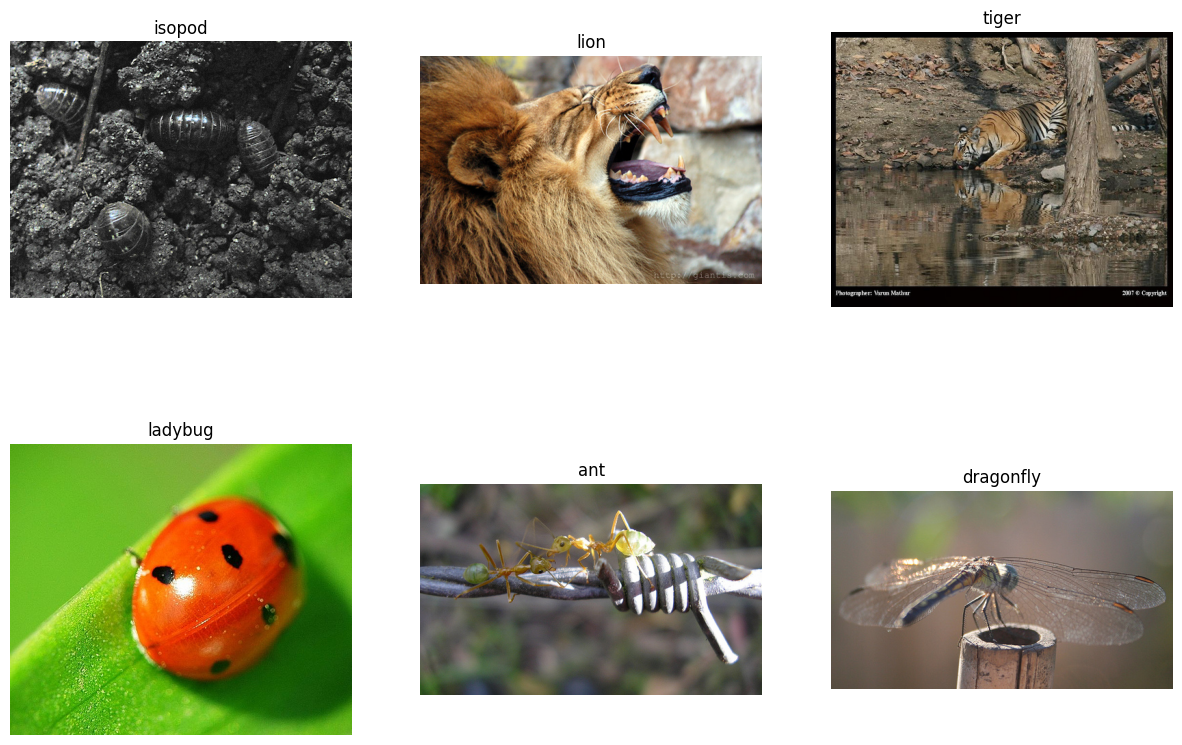

In [ ]:
import torch
from torchvision.transforms import v2


def img2tensor(img):
    transform = v2.Compose(
        [
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    t = transform(img)
    return t


def catId2names(nums):
    titles = []
    for num in nums:
        titles.append(imagenet_labels[str(num.item())][1])
        titles.reverse()
    return ", ".join(titles)


for i in range(6, 12):
    img, label = microImgNet[i * 6]
    tensor = img2tensor(img)
    out = alexnet(tensor.unsqueeze(0))  # Add batch dimension
    labels_num = torch.argsort(out[0])  # Ascending order
    weights = out[0][-5:]
    predicted = catId2names(labels_num[-5:])  # Top 5
    titles = []
    name = microImgNet.labels[i * 6][1]
    show(img, name, i - 6, predicted)

## Тюнинг гиперпараметров (ZFnet)

[[arxiv] 🎓 Visualizing and Understanding Convolutional Networks (Zeiler et al., 2013)](https://arxiv.org/abs/1311.2901)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/zfnet_architecture.png"  width="1000"><center>

<center><em>Архитектура сети ZFNet </em><center>



*Тюнингованный AlexNet*

Нейросеть **ZFNet**, созданная учеными из Йорского университета в 2013 году, выиграла соревнования, уменьшив ошибку по top-5 до 11.7%. В ней **AlexNet** использовалась в качестве основы, но с изменёнными параметрами и слоями.

Отличия от **AlexNet** небольшие:
* немного поменялись пространственные размеры фильтров (было 11, стало 7),
* увеличилось общее количество фильтров.

Количество слоев и общая структура сети, когда слои свёртки и pooling-слои чередуются друг с другом, а затем идут два полносвязных слоя, сохранились.

# Базовый блок (VGGNet 2014)


[[arxiv] 🎓 Very Deep Convolutional Networks for Large-Scale Image Recognition (Simonyan et al., 2014)](https://arxiv.org/abs/1409.1556)

Karen Simonyan ([выпускник МГУ ✏️[blog]](https://cs.msu.ru/news/3976 ), участник Visual Geometry Group — **Oxford**) and Andrew Zisserman ([Visual Geometry Group — **Oxford** ✏️[blog]](https://www.robots.ox.ac.uk/~vgg/index.html)).


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/vggnet_architecture.png"  width="400"></center>
<center><em>Сравнение архитектур сетей AlexNet, VGG16 (использует 16 слоев) и VGG19 (использует 19 слоев)</em></center>




[[doc] 🛠️ Краткое описание VGGNet](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

В 2014-ом году в Оксфорде была разработана модель **VGGNet**.

В архитектуре **VGGNet** появляется идея повторения стандартных блоков и увеличения глубины нейросети повторением таких блоков (**stacking**). На момент создания данной архитектуры идея увеличения глубины нейросети для получения лучших результатов не была очевидна. Стандартный блок **VGGNet** состоит из нескольких слоев свертки (от 2 до 4) и max-pooling слоя.

Существует несколько вариантов **VGGNet** архитектуры. Самые известные: **VGG11**, **VGG16** и **VGG19**. Цифра ставится по количеству слоев с обучаемыми весами: сверточных и полносвязных.

На изображении выше показаны сети **AlexNet** и две версии **VGG16** и **VGG19** с 16 и 19 обучаемыми слоями соответственно. И, хоть **VGGNet** заняла 2-е место в задаче классификации, а 1-е место — в задаче локализации (классификация и обводка объекта ограничивающей рамкой) на **ImageNet**, она получила широкое признание благодаря своей простой архитектуре. В следующие годы в соревновании встречалось много вариаций архитектур, основанных на базе **VGGNet**, и до сих пор [модификации VGG (RepVGG) 🎓 [arxiv]](https://arxiv.org/pdf/2101.03697.pdf) применяются в качестве экстрактора признаков в некоторых вариациях YOLO и задаче Style Transfer.


Особенности архитектуры **VGGNet**:
* сверточные слои  **объединены в блоки**, состоящие из некоторого количества свёрток с разным (постепенно увеличивающимся от блока к блоку) количеством фильтров;
* все свёрточные слои имеют фильтры с рецептивным полем размера **3×3**;
* между блоками располагаются pooling-слои.

Появление "стандартных" блоков внутри модели — важное нововведение. Идея базового блока внутри сети будет достаточно широко использоваться дальше.

In [ ]:
from torchvision import models

vgg = models.vgg16(
    weights=None
)  # Change on True if you want to use VGG to predict something
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Чтобы понять смысл использования сверток $3\times3$, необходимо познакомиться с понятием рецептивного поля и научиться оценивать количество необходимых вычислительных ресурсов.

## Вычислительные ресурсы



Какие ресурсы нужны для работы нейронной сети?
* Память для хранения карт активаций.
* Память для обучаемых параметров (весов).
* Вычислительные ресурсы.


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/weights_memory.png"  width="650"></center>
<center><em>Расчет числа операций (FLOP) для сверточного слоя</em></center>

Для случая, когда количество каналов не меняется, фильтры и изображения квадратные, `stride = 1` и `padding = "same"`:

$$ \large \text{weights} = K^2C^2 $$

$$ \large \text{flops} = K^2C^2HW $$





$\color{orange}{\text{Оранжевый тензор}}$ — карта признаков, поступившая на вход сверточного слоя. Параметры $H_{in}$, $W_{in}$, $C_{in}$ — длина, ширина и глубина (число каналов изображения или фильтров в предыдущем сверточном слое) входного тензора. Данный тензор не учитывается в используемых ресурсах, т.к. информация сохранена в предыдущем слое.

**Память для хранения промежуточных представлений** определяется **количеством элементов на выходе слоя** ($\color{blue}{\text{синий тензор}}$). Они хранятся для вычисления следующих слоев и градиентов. Необходимая память рассчитывается как:

$$\large H_{out}⋅W_{out}⋅C_{out}⋅n_{byte},$$

где $H_{out}, W_{out}, C_{out}$ — длина, ширина и глубина (число фильтров в свертке) выходной карты признаков, а $n_{byte}$ — количество байт для хранения одного элемента ($4$ для `float32`).


**Память для обучаемых параметров** определяется **весами и смещением** (bias) фильтров свертки ($\color{green}{\text{зеленые тензоры}}$). Необходимая память рассчитывается как:

$$\large (K_h⋅K_w⋅C_{in}⋅C_{out} + C_{out})⋅n_{byte},$$

где $K_h, K_w, C_{in}$ — длина, ширина и число каналов входного тензора, $C_{out}$ — число фильтров в свертке.

Для оценки необходимых **вычислительных ресурсов** посчитаем **количество операций** сложения и умножения при прямом проходе. Каждый элемент выходного тензора — это результат применения фильтра свертки к определенному фрагменту входного тензора. Количество операций можно оценить как произведение количества элементов на выходе слоя на размер одного фильтра:

$$\large (H_{out}⋅W_{out}⋅C_{out})⋅(K_h⋅K_w⋅C_{in})$$

**Оценка памяти для хранения параметров слоя:**

In [ ]:
import torch.nn as nn

conv_sizes = [11, 7, 5, 3]

for conv_size in conv_sizes:
    conv_layer = nn.Conv2d(3, 64, conv_size, stride=1, padding=1)
    print("Convolution size: %ix%i" % (conv_size, conv_size))
    for tag, p in conv_layer.named_parameters():
        print("Memory reqired for %s: %.2f kb" % (tag, (np.prod(p.shape) * 4) / 1024))

Convolution size: 11x11
Memory reqired for weight: 90.75 kb
Memory reqired for bias: 0.25 kb
Convolution size: 7x7
Memory reqired for weight: 36.75 kb
Memory reqired for bias: 0.25 kb
Convolution size: 5x5
Memory reqired for weight: 18.75 kb
Memory reqired for bias: 0.25 kb
Convolution size: 3x3
Memory reqired for weight: 6.75 kb
Memory reqired for bias: 0.25 kb


**Оценка количества вычислительных операций (для одной свертки):**

* $11×11: (224 * 224 * 64) * (3 * 11 * 11) = 9 633 792 * 11 * 11 =  9 633 792 * 121  = 1\,165\,688\, 832$

* $7×7: (224 * 224 * 64) * (3 * 7 * 7) = 9 633 792 * 7 * 7 = 9 633 792 * 49 = 472\,055\,808$

 $121:49 \approx 2.5 ⟶ $ в $\approx 2.5$ раза меньше, чем $11×11$

* $5×5: (224 * 224 * 64) * (3 * 5 * 5) = 9 633 792 * 5 * 5 = 9 633 792 * 25 = 240\, 844\, 800$

 $49:25 \approx 2 ⟶ $ в $\approx 2$ раза меньше, чем $7×7$

* $3×3: (224 * 224 * 64) * (3 * 3 * 3) = 9 633 792 * 3 * 3 = 9 633 792 * 9 = 86\, 704\, 128$

 $25:9 \approx 2.7$ ⟶ в $\approx 2.7$ раза меньше, чем $5×5$


Уменьшение размера ядра свертки приводит к существенному уменьшению количества вычислительных операций.







### Фильтры 3×3

**Рецептивное поле нейрона** — это область входного изображения, данные из которой использовались при формировании признаков, которые подаются на вход данному нейрону (фильтру). **Рецептивное поле** можно назвать “полем зрения”.

Интуитивно кажется, что чем больше “поле зрение”, тем лучше обобщающая способность свертки. Авторы **VGG** решили отказаться от свертки **5×5** и заменить ее двумя свертками **3×3**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/receptive_field_size.png" width="800"></center>
<center><em>Две свёртки 3×3 вместо одной 5×5</em></center>


Рассмотрим **рецептивное поле** свертки **5×5** ($\color{green}{\text{зеленый квадрат}}$). Применение свертки **5×5** к этому квадрату даст 1 признак на выходе. Применение к **рецептивному полю** такого же размера свертки **3×3** ($\color{orange}{\text{оранжевый квадрат}}$ ) даст карту признаков **3×3** ($\color{red}{\text{красный квадрат}}$), применение второй свертки **3×3** позволит получить 1 признак на выходе ($\color{red}{\text{красный квадрат}}$ ).

**Итого:** одна свертка **5×5** имеет то же **рецептивное поле**, что две свертки **3×3**.

При этом применение двух сверток **3×3** дает ряд преимуществ:

* меньшее количество параметров. При применении свертки **5×5** необходимо обучить $5⋅5⋅C_{in}⋅C_{out} = 25⋅C_{in}⋅C_{out}$  весов, где $С_{in}$ — глубина входной карты признаков, $C_{out}$ — количество фильтров сверточного слоя. При применении двух сверток **3×3** обучается $2⋅(3⋅3⋅C_{in}⋅C_{out}) = 18⋅C_{in}⋅C_{out}$  весов.
* между свертками **3×3** добавляется дополнительный **слой активации**, который позволяет формировать более сложные признаки.


Аналогично 3 свертки **3×3** могут заменить одну свертку **7×7**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/receptive_field_size_example.png"  width="850"></center>
<center><em>Три свёртки 3×3 вместо одной 7×7</em></center>


### Память для хранения параметров (VGG16)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/memory_and_parameters_vgg16.png"  width="800"></center>
<center><em>Архитектура VGG16 с параметрами слоев </em></center>

Благодаря такой экономии получилось сделать большую по тем временам сеть (16 слоев).  Тем не менее, несмотря на применённые способы уменьшения вычислительной сложности и снижение числа параметров, сеть все равно получилась огромной (16-слойная версия сети VGG расходует в 25 раз больше дорогой памяти GPU, нежели AlexNet).

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/compare_parameters_alexnet_and_vgg16.png"  width="900"></center>
<center><em>Сравнение параметров AlexNet и VGG16</em></center>


* Основная часть памяти расходуется на свёртки в начальных слоях, где пространственные размеры (ширина и высота) велики.
* Больше всего весов в полносвязных слоях.
* Вычислительные ресурсы нужны в первую очередь для сверток.

VGG16 получилась существенно больше по сравнению с и так довольно объемной AlexNet, и тем более по сравнению с современными моделями.

В значительной степени с этим связано дальнейшее направление развития моделей. В следующем году ImageNet выиграла сеть под названием **GoogleNet**.

# Inception module (GoogLeNet 2014)

[[arxiv] 🎓 Going Deeper with Convolutions (Szegedy et al., 2014)](https://arxiv.org/abs/1409.4842)

**GoogLeNet** — ещё более глубокая архитектура с 22 слоями. На самом деле архитектура называется **Inception**, а **GoogLeNet** — это имя команды в соревновании  [**ILSVRC14** 🛠️[doc]](https://www.image-net.org/challenges/LSVRC/2014/), названной так в честь нейронной сети Яна Лекуна **LeNet 5**, но до сих пор первую версию сети **Inception** называют **GoogLeNet**.

В отличие от предыдущих нейросетей, **GoogLeNet** разработана в коммерческой компании с целью практического применения, поэтому основной упор был сделан на эффективность.

Она содержит менее 7 миллионов параметров — в 9 раз меньше, чем у **AlexNet**, и в 20 раз меньше, чем у **VGG19**. При этом сеть оказалась немного более точной, чем **VGG19**: ошибка снизилась с 7.3% до 6.7%.

Рассмотрим, за счёт чего удалось достичь такого огромного выигрыша в ресурсах, так как многие идеи, которые впервые были использованы в **GoogLeNet**, активно применяются до сих пор.

Составной блок **GoogLeNet** называется **Inception module**. Архитектура **GoogLeNet** состоит из множества таких блоков, следующих друг за другом.

Идея **Inception module** состоит в том, чтобы производить параллельные вычисления сверток с различным размером рецептивного поля и Max Pooling, конкатенируя (объединяя, а не складывая) полученные результаты. Это позволяет выделять признаки разного размера и сложности.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/naive_inception_module.png" width="500"></center>
<center><em>Наивная реализация Inception module </em></center>

На рисунке выше представлена наивная реализация **Inception module**. Данная реализация имеет очень важный недостаток: **увеличение глубины карты признаков**. За счет конкатенации выходов **сверток** и **Max Pooling** из 256 каналов на входе мы получаем 672 канала на выходе. Количество каналов изображения увеличилось более чем в 2.6 раза. За 9 таких блоков глубина увеличится более чем в 5000 раз!

Такое решение плохо совместимо с экономией ресурсов.

Стоит также заметить, что слой **Max Pooling** в данной архитектуре имеет шаг 1 и не изменяет пространственные размеры карты признаков.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/naive_inception_module_with_dimension_reduction_parameters.png" width="500"></center>
<center><em> Реализация Inception module с уменьшением размерности </em></center>


Как мы уже показали, при использовании наивной реализации **Inception module** количество фильтров возрастает от слоя к слою.

Чтобы этого избежать, введены так называемые **«бутылочные горлышки»** — слои с фильтром **1×1**, уменьшающие глубину карт признаков. Благодаря им удалось достичь того, чтобы количество каналов на входе и на выходе либо не менялось, либо менялось только в моменты, когда это необходимо.

Интересно, что слой свертки **1×1** ставится после слоя **Max Pooling**. Это позволяет более эффективно преобразовывать признаки, регулируя количество каналов.

In [ ]:
import torchvision

# https://pytorch.org/vision/stable/_modules/torchvision/models/googlenet.html#googlenet
googlenet = torchvision.models.googlenet(init_weights=True)
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

##### 1×1 Convolution





<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/1x1_convolution.png"  width="550"></center>
<center><em>Уменьшение глубины изображения с помощью 32 фильтров 1×1</em></center>


Свёртку **1×1** можно сравнить с линейным слоем полносвязной нейронной сети. Мы берем вектор из карты признаков (столбик 1×1×64 на картинке) и домножаем на матрицу весов (одну для всех векторов, в данном случае матрица будет 64×32, т.к. она составлена из 32 фильтров с размерами 1×1×64), чтобы получить вектор на выходе (столбик 1×1×32 на картинке).

В процессе формируются новые признаки, агрегирующие информацию из разных каналов, и количество каналов сокращается.

Количество параметров уменьшается в два с лишним раза по сравнению с наивной реализацией. Сеть получается значительно экономичнее.

Использование таких модулей и отсутствие полносвязных слоёв делают **GoogLeNet** очень эффективной и достаточно точной сетью. Но это далеко не все нововведения, которые появились в этой модели.

## Stem network

В составе **GoogLeNet** есть небольшая подсеть — **Stem Network**. Она состоит из трёх свёрточных слоёв (первый с большим фильтром) с двумя pooling-слоями и располагается в самом начале архитектуры. Цель этой подсети — быстро и сильно уменьшить пространственные размеры (сжать изображение перед параллельной обработкой), чтобы минимизировать количество элементов в слоях.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/stem_network.png" width="1024"></center>
<center><em>Архитектура GoogLeNet. В первых слоях быстро уменьшаются пространственные размеры</em></center>

## Global Average Pooling

Отдельного внимания заслуживает завершающая часть сети. В **AlexNet** и **VGGNet** мы привыкли видеть в конце сети вытягивание карты признаков в вектор и два полносвязных слоя. В **GoogLeNet** один из полносвязных слоев заменен на
**Global Average Pooling**.

[[arxiv] 🎓 Network In Network, Lin et al., 2013](https://arxiv.org/abs/1312.4400)



Этот слой просто усредняет все значения в канале. На выходе получаем вектор признаков, количество элементов в котором равно количеству каналов.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/global_average_pooling.png" width="450"></center>
<center><em>Global Average Pooling</em></center>

Плюсы **GAP**:
* независимость от размера входа,
* регуляризация (препятствует переобучению),
* уменьшение числа параметров.


В PyTorch можно реализовать GAP при помощи класса `nn.AdaptiveAvgPool2d` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html). При создании экземпляра класса указываем, какую пространственную размерность мы хотим получить на выходе. При `output_size=1`получим результат как на иллюстрации.

In [ ]:
gap = torch.nn.AdaptiveAvgPool2d(1)
dummy_input = torch.randn(1, 3, 6, 6)
out = gap(dummy_input)
print("Raw out shape", out.shape)
out = nn.Flatten()(out)
print("Flatten out shape", out.shape)

Raw out shape torch.Size([1, 3, 1, 1])
Flatten out shape torch.Size([1, 3])


[[blog] ✏️ Max Pooling and Global Average Pooling](https://github.com/christianversloot/machine-learning-articles/blob/main/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling.md)

Ранее считалось, что применение **Global Average Pooling** в сверточной нейронной сети приведёт к полной потере пространственной информации об объекте на изображении. Тем не менее, последние [исследования 🎓[arxiv]](https://arxiv.org/abs/2108.07884) показывают, что после такого преобразования часть пространственной информации всё же сохраняется. Несмотря на то, что семантическая информация (например, информация о точных границах объекта) полностью утрачивается после Global Average Pooling, информация об абсолютном положении объекта на исходном изображении сохраняется и оказывается закодированной порядком следования компонент в оставшемся векторе усреднённых фильтров.

Применяя **GAP**, мы сократили количество признаков в 49 раз! Кроме того, **Global Average Pooling** уменьшает переобучение, т.к. мы избавляемся от влияния менее важных признаков.

In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import v2
from PIL import Image


def file2tensor(filename):
    img = Image.open(filename)
    transform = v2.Compose(
        [
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    t = transform(img)
    return t


class CNNfromHW(nn.Module):
    def __init__(self, conv_module=None):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)  # 16xHxW
        self.pool = nn.MaxPool2d(2, 2)  # 16 x H/2 x W/2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 32 x H/2 x W/2
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Any spatial size -> 32x1x1
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        print("Input shape", x.shape)
        x = self.conv1(x)  # 16xHxW
        x = self.pool(x)  # 16 x H/2 x W/2
        x = self.conv2(x)  # 32 x H/2 x W/2
        x = self.activation(x)  # Any spatial size -> 32x1x1
        x = self.gap(x)
        scores = self.fc(x.flatten(1))
        print("Output shape", scores.shape)
        return scores


print("CIFAR10 like")
input_random = torch.rand(1, 3, 32, 32)
model_with_gap = CNNfromHW()
out = model_with_gap(input_random)


print("Arbitrary size")
# Different sizes work too!
armadillo_t = file2tensor("imagen/n02454379_10511_armadillo.jpg")
out = model_with_gap(armadillo_t.unsqueeze(0))

CIFAR10 like
Input shape torch.Size([1, 3, 32, 32])
Output shape torch.Size([1, 10])
Arbitrary size
Input shape torch.Size([1, 3, 500, 500])
Output shape torch.Size([1, 10])


## Затухание градиента

**GoogLeNet: дополнительный классификатор**

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/googlenet_additional_classificator.png"  width="900"></center>
<center><em>Архитектура GoogLeNet. Отдельно вынесен блок — дополнительный классификатор</em></center>


Как мы уже знаем, существует проблема затухания градиента в глубоких сетях. Статья про батч-нормализацию появилась в 2015-ом году. Как же обучали GoogLeNet?

Помимо основного классификатора на выходе сети добавлены два дополнительных классификатора, встроенные в промежуточные слои. Они понадобились для того, чтобы улучшить обратное распространение градиента: без батч-нормализации в таких глубоких сетях градиент очень быстро затухал, и обучить сеть такого размера было серьёзной проблемой.

Обучение VGG осуществлялось непростым способом: сначала обучали 7 слоев, затем добавляли туда следующие и обучали это вручную. Без использования батч-нормализации вряд ли получится повторить результат.

Google подошел более системно, добавив дополнительные выходы, которые способствовали тому, чтобы градиент меньше затухал. Благодаря этому удалось решить серьёзную на тот момент проблему, которая ограничивала возможность обучения глубоких моделей.

# BatchNorm (революция глубины)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/deep_models.png"  width="750"></center>
<center><em>Победители ImageNet Large Scale Visual Recognition Challenge (ILSVRC)</em></center>


В 2015 году вышла статья [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift 🎓[arxiv]](https://arxiv.org/abs/1502.03167). Благодаря добавлению слоя BatchNorm стало технически возможно обучать сети, состоящие из десятков слоев.

Но точность с увеличением глубины не росла:

[[arxiv] 🎓 Deep Residual Learning for Image Recognition (He et al., 2015)](https://arxiv.org/abs/1512.03385)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/resnet_20_and_56_layers.png" width="550"></center>
<center><em>График ошибки на обучающей и тестовой выборках двух модификаций
VGGNet с 20 и 56 слоями соответственно в ходе процесса обучения </em></center>

На графике выше приведено сравнение графиков обучения 56-слойной и 20-слойной сетей Microsoft, построенных на принципах VGGNet. Как видно из графиков, у 56-слойной сети и на тренировочном, и на тестовом датасете ошибка больше, чем у 20-слойной. Казалось бы, сеть, состоящая из большего количества слоёв, должна работать как минимум не хуже, чем сеть меньшего размера.

В 2015 году соревнования выиграла сеть **ResNet**, архитектура которой предлагала новый подход к решению проблемы обучения глубоких сетей. Она состояла из 152 слоёв и снизила процент ошибок до 3,57%. Это сделало её почти в два раза эффективнее **GoogLeNet**.

# Skip connection (ResNet 2015)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/residual_connection.png" width="800"></center>
<center><em>Сравнение Residual Block с "обычными" слоями</em></center>



Архитектура **ResNet** состоит из набора так называемых **Residual Block**-ов. В данном блоке тензор входных признаков пропускается через пару последовательно соединённых свёрточных слоёв, после чего полученный результат складывается поканально с этим же неизменённым входным тензором. Свёрточные слои в таком блоке аппроксимируют не саму функциональную зависимость между входным и выходным тензором, а разность (анг. residual) между такой искомой зависимостью и тождественным преобразованием.

Идея **Residual Block** состоит в уточнении набора признаков на каждом блоке. Вместо того, чтобы перезаписывать признаки, мы добавляем к выходу предыдущего блока уточнение, сформированное на этом блоке.

Бонусы **Residual Block**:
- канал суммирования позволяет градиенту легко распространяться без затухания,
- не теряется информация о важных признаках, выделенных на предыдущем слое.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/basicblock_identity.png" width="900"></center>
<center><em>Residual Block без downsample</em></center>


## Архитектура ResNet

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/resnet_architecture.png"  width="730"></center>
<center><em>Архитектура ResNet. Используются stacking residual blocks, каждый residual block состоит из двух 3×3 свёрточных слоев. Периодически количество фильтров в свертках удваивается, а размер выходных слоев уменьшается в 2 раза (за счет stride=2). Добавился дополнительный свёрточный слой в начале сети. Отсутствуют FC слои (кроме последнего, который предсказывает класс).</em></center>


Из таких блоков можно построить очень глубокую сеть (были эксперименты из 1000 слоев). Для решения конкретной задачи — победы на **ImageNet** — хватило 150 слоев (добавление большего количества блоков уже не давало прироста точности).

В **ResNet** используются многие идеи, которые присутствовали в предыдущих моделях:
- вначале изображение резко уменьшается,
- дальше используются блоки 3×3, как в **VGGNet**,
- применяется **Average Pooling** вместо полносвязного слоя.

Блоки состоят из конструкций, изображенных выше:
- две свёртки 3×3,
- batch normalization после каждой свертки,
- функции активации ReLU,
- прибавление результата предыдущего слоя.

## BasicBlock в PyTorch




Код базового блока:

In [ ]:
import inspect
import torchvision.models.resnet as resnet

# BasicBlock
code = inspect.getsource(resnet.BasicBlock.forward)
print(code)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out



Так выглядит в коде базовый блок для сетей, в которых меньше 50 слоёв: свёртка, батч-нормализация, активация, свёртка, батч-нормализация.

Если свойство `downsample != None`, то вызывается слой **downsample**. Это свёртка 1×1 с шагом 2, уменьшающая пространственные размеры карты признаков.

[[doc] 🛠️ Модель ResNet на Torchvision](https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html#resnet18)


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/basicblock_downsample.png" width="900"></center>
<center><em>Residual Block с downsample</em></center>


Вот как инициализируются блоки (в первом сжатие происходит, во втором — нет).

In [ ]:
from torchvision import models

resnet = models.resnet18(weights=None)
print(resnet.layer2)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

## Bottleneck layer

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/resnet_bottleneck_layer.png" width="500"></center>
<center><em>В более глубоких сетях (ResNet-50+) для повышения эффективности используется слой "bottleneck" (похожим образом, что и в GoogLeNet)</em></center>

Стоит отметить, что сеть **ResNet-152** имеет существенно меньше обучаемых параметров, чем **VGG19** (58 миллионов против 144 миллионов).

Это достигнуто за счёт того, что в более глубоких сетях, помимо упомянутых Residual Block-ов с двумя свёрточными слоями с ядром 3×3, применялся более эффективный блок — **bottleneck**, состоящий из:
- свёртки 1×1 с уменьшением количества фильтров,
- свертки 3×3 с маленьким количеством фильтров,
- свертки 1×1, восстанавливающей количество фильтров до начальных значений, чтобы к ним можно было прибавить вход.

## Stage ratio

`Stage ratio` — частота, с которой уменьшаются пространственные размеров карты признаков. Обычно записывается как последовательность чисел, например, `[2,2,2,2]`.

Эта запись означает, что в модели 8 базовых блоков и downsampling происходит на каждом втором, что соответствует 18-слойной модели из статьи:


<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/stage_ratio.png" width="700"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition (He et al., 2015)</a></em></center>


Соответственно для ResNet-34 stage ratio будет $[3,4,6,3]$,
для ResNet-50 — $[3,4,6,3]$, а для  ResNet-101 — $[3,4,23,3]$.

## Обучение ResNet

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/resnet_18_and_34_layers.png"  width="700"></center>
<center><em>График изменения ошибки при обучении двух модификаций ResNet с 34 и 18 слоями соответственно</em></center>


При обучении **ResNet** шаг обучения понижали вручную, когда точность выходила на плато.

Помимо того, что **ResNet** в 2015 году c огромным отрывом выиграла ImageNet у моделей прошлого года, она стала первой моделью, превысившей точность человеческой разметки. Решения на базе этой архитектуры также стали победителями на соревнованиях по детектированию и сегментации.

### Обогащение карт признаков

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/resnet_features_flow.png"  width="900"></center>

Можно взглянуть на архитектуру ResNet под таким углом: на первых слоях мы получаем базовую карту признаков, а на последующих улучшаем ее, прибавляя к ней новые уточненные признаки.

# Grouped Convolution



В AlexNet выходы первого слоя обрабатывались параллельно: половина каналов отправлялась на одну видеокарту, а половина — на другую.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/alexnet_architecture.png" width="800"></center>


Только на некоторых слоях полученные признаки объединялись.

Можно рассматривать такой подход как ансамблирование, но, как минимум, он позволяет выполнять часть операций параллельно и таким образом ускорить вычисления.

Эта идея реализуется при помощи Grouped convolution.  Можно поканально разделить входной тензор признаков на произвольное количество частей (групп) и сворачивать их независимо.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/grouped_convolution.png" width="750"></center>
<center><em> Grouped Convolution с двумя группами сверток. Групповые свертки позволяют обрабатывать входные данные параллельно. В качестве бонусов — уменьшение числа параметров и дополнительная регуляризация.</em></center>



[[blog] ✏️ A Tutorial on Filter Groups (Grouped Convolution)](https://blog.yani.ai/filter-group-tutorial/)

На картинке выше входная карта признаков разбивается на две группы по каналам. Над каждой группой свертки вычисляются независимо, а потом конкатенируются. Это позволяет заменить $D_{out}$ фильтров $H_{in} × H_{in} × D_{in}$ на $D_{out}$ фильтров $H_{in} × H_{in} × D_{in}/2$, сократив количество обучаемых весов в 2 раза.

Для обычных светок:

$$ \large \text{weights} = K^2C^2 $$

$$ \large \text{flops} = K^2C^2HW $$


Так как размер ядер станет меньше, получим для $G$ групп выигрыш в производительности:

$$ \large \text{weights} = \frac{C}{G} C K^2$$

$$ \large \text{flops} =  \frac{C}{G} K^2CHW$$

## Grouped Convolution in PyTorch


Возможность вычисления групповой свертки в PyTorch заложена в объект  `nn.Conv2d`. Количество групп задается параметром `groups`, значение которого по умолчанию равно 1.

Сравним время, которое требуется на обычную свертку с `groups=1` и свертку с `groups=64` при вычислениях на CPU:

In [ ]:
# CPU test
import time
import torch
from torch import nn


def time_synchronized():
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()


input_random = torch.rand(8, 512, 112, 112)
start = time_synchronized()
normal_conv = nn.Conv2d(512, 1024, 3, groups=1)
out = normal_conv(input_random)
tm = time_synchronized() - start
print(f"Normal convolution take  {tm} sec.")

start = time_synchronized()
grouped_conv = nn.Conv2d(512, 1024, 3, groups=64)
out = grouped_conv(input_random)
tm = time_synchronized() - start
print(f"Grouped convolution take  {tm} sec.")

Normal convolution take  9.28431749343872 sec.
Grouped convolution take  0.8012826442718506 sec.


И на GPU:

In [ ]:
# GPU test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
start = time_synchronized()
normal_conv = nn.Conv2d(512, 1024, 3, groups=1).to(device)
out = normal_conv(input_random.to(device))
tm = time_synchronized() - start
print(f"Normal convolution take  {tm} sec.")

start = time_synchronized()
grouped_conv = nn.Conv2d(512, 1024, 3, groups=64).to(device)
out = grouped_conv(input_random.to(device))
tm = time_synchronized() - start
print(f"Grouped convolution take  {tm} sec.")

Normal convolution take  0.8534040451049805 sec.
Grouped convolution take  0.1581711769104004 sec.


Применение групповой свертки с `groups=64` дает выигрыш во времени. Это связано с уменьшением количества вычислительных операций.

## ResNeXt

Следующая модель — **ResNeXt**. Эта сеть выиграла **ImageNet** в следующем году. Идея немного напоминает блок **Inception** в **GoogLeNet**: обрабатывать не сразу все каналы, а распараллелить обработку на несколько групп.

[[arxiv] 🎓 Aggregated Residual Transformations for Deep Neural Networks (Xie et al., 2016)](https://arxiv.org/abs/1611.05431)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/compare_resnet_and_resnext_blocks.png"  width="650"></center>
<center><em>Сравнение блоков ResNet и ResNeXt. ResNeXt создан тем же коллективом авторов, что и ResNet. Увеличение ширины residual block достигается путем использования параллельных веток "cardinality"), которые по духу схожи с Inception module. </em></center>

ResNeXt объединяет идеи:
* Skip connection
* Inception  
* Grouped convolution


In [ ]:
from torchvision import models
from torchsummary import summary

resnext = models.resnext50_32x4d(weights=None)

print(summary(resnext, (3, 224, 224), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/resnext_inception_grouped_convolution.png"  width="1000"></center>


[[blog] ✏️ Review of ResNet Family: from ResNet to ResNeSt](https://sheng-fang.github.io/2020-05-20-review-resnet-family/)

Альтернативой для блока **ResNeXt** (рисунок слева) является блок **Inception-ResNeXt** (рисунок посередине), объединивший идеи **ResNeXt** блока и **Inception** блока. Применение таких блоков вместо **ResNeXt** позволяет немного улучшить результаты **ResNeXt**.

##Обзор сети MobileNet (2017 г.)

[[arxiv] 🎓 MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications (Howard et al., 2017)](https://arxiv.org/abs/1704.04861)

**MobileNet** — архитектура нейронной сети, специально созданная для работы на CPU мобильных устройств. Высокая скорость работы первой версии **MobileNet** достигалась благодаря разделимой по глубине свертке (**Depthwise Separable Convolution**).

Также для данной архитектуры предусматривается возможность варьировать размер входного изображения и ширину слоев.

В качестве функции активации у **MobileNet** может использоваться **ReLU6** (ограничение сверху у данной функции активации призвано облегчить дальнейшую 8-битную квантизацию нейронной сети), хотя часто по умолчанию используют **ReLU**.

В 2018 году была предложена архитектура **MobileNetV2**, которая существенно превзошла первую версию благодаря добавлению к архитектуре инвертированных остаточных блоков (**Inverted Residual Block**).

А в 2019 году была предложена уже **MobileNetV3**, которая была получена при помощи автоматического поиска архитектуры (**Network Architecture Search**) и дополнительно включала в себя модули **squeeze-and-excitation** и немонотонную функцию активации **swish** ("жесткая" версия которой, hard-swish, также призвана облегчить квантизацию).

Давайте разберемся, как все эти улучшения работают.

### Depthwise separable convolution

Обычная свертка в **CNN** одновременно работает с шириной, высотой и глубиной (каналами) карты признаков. Разделимая по глубине свёртка (**Depthwise separable convolution**) разделяет вычисления на два этапа:
- Для каждого канала изображения используется свой отдельный сверточный фильтр глубины 1.  По сути это **Grouped Convolution** с количеством групп, равным числу каналов.
- После вычисляется свертка 1×1 с глубиной, равной глубине входной карты признаков.

Применение разделимой по глубине свертки позволяет уменьшить количество обучаемых параметров и вычислительных операций при небольшой потере точности.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/depthwise_and_separable_convolution.png"  width="650"></center>

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/depthwise_separable_convolution.png"  width="650"></center>

$\text{DepthwiseSeparableConv} = \text{GroupedConv}(\text{group} = C) + \text{Conv}(1×1)$

Количество обучаемых параметров (весов):
* для $\text{Conv2d}: \qquad \qquad \qquad \qquad \text{weights} = C^2K^2 $
* для $\text{DepthwiseSeparableConv}: \ \text{weights} = C K^2  + C^2\times1 $

Чем больше каналов, тем больше экономия.

При размере ядра $3×3$ $(K=3)$ :

$\text{Conv2d}: \qquad \qquad \qquad \qquad 3^2 C^2 $

$\text{DepthwiseSeparableConv}: \ 3^2C +C^2$


### Inverted residual block

Инвертированный остаточный блок (**Inverted residual block**) напоминает классический **residual block** из архитектуры **ResNet**, однако имеет ряд существенных отличий. Дело в том, что классический **residual block** из-за резкого уменьшения размерности пространства в комбинации с функцией активации **ReLU**, которая зануляет отрицательные значения, приводит к потере большого количества информации.

Поэтому вместо уменьшения количества слоев в *середине*, оно, наоборот, увеличивается. Увеличение вычислительной сложности компенсируется использованием разделимой по глубине свертки. А на входе и выходе из блока (где количество слоев уменьшается) отсутствует нелинейность (**ReLU**).

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/residual_block_and_inverted_residual_block.png" width="550"></center>

# Сравнение моделей

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/compare_models_accuracy_vs_parameters.png" width="600"></center>

<center><em>Сравнение моделей по параметрам Точность и Количество операций</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1810.00736.pdf">Benchmark Analysis of Representative Deep Neural Network Architectures (Bianco et al., 2018)</a></em></center>

Картинка из статьи 2018 года, но она позволяет визуально сравнить модели по трем параметрам:
- размер модели (размер кружка),
- количество необходимых для обучения вычислительных операций (ось $x$),
- точность на задаче top-1 (ось $y$).

Здесь можно увидеть, что **VGGNet** — огромные по объёму модели, но по нынешним меркам они обладают средней точностью. Они требуют больших вычислительных ресурсов, поэтому сейчас имеет смысл их использовать разве что в учебных целях. А модели на базе **ResNet** (**ResNet-50**, **ResNet-152**) довольно хороши: в плане точности какого-то большого отрыва от них здесь не видно. Но, тем не менее, есть модели, которые работают гораздо лучше. Рассмотрим их кратко, чтобы было понимание того, куда двигалась мысль в этой области.

## Много skip connection (DenseNet 2016)

[[arxiv] 🎓 Densely Connected Convolutional Networks (Huang et al., 2016)](https://arxiv.org/abs/1608.06993)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/densenet_architecture.png"  width="450"></center>
<center><em>Архитектура DenseNet: используется несколько "обходов" и конкатенация вместо суммы</em></center>



В DenseNet каждый слой получает в качестве входа не только выход предыдущего слоя, но и выходы предыдущих слоёв. Это решает проблему затухания градиента и позволяет эффективно использовать параметры модели, поскольку информация передаётся напрямую через всю сеть.


Можно также заменить сумму на конкатенацию. Чтобы не увеличить при этому глубину карт признаков, можно использовать свёртки **1×1**.

На этих двух принципах построен **DenseNet**. С точки зрения ресурсов он чуть более требовательный, чем базовый **ResNet**, и немного более точный.

## Ширина вместо глубины (WideResNet 2016)

[[arxiv] 🎓 Wide Residual Networks (Zagoruyko et al., 2016)](https://arxiv.org/abs/1605.07146)

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/compare_basic_and_wide_residual_blocks.png" width="400"></center>
<center><em>Сравнение базового ResBlock и "широкого" ResBlock, где используются $F × k$ фильтры вместо $F$ фильтров в каждом слое </em></center>

Другой подход состоит в том, чтобы увеличивать не глубину, а ширину модели.
Авторы утверждают, что ширина (количество фильтров) **residual** блока — значительно более важный фактор, чем глубина нейронной сети. 50-слойный **Wide ResNet** показывает лучшие результаты, чем оригинальный 152-х слойный **ResNet**. С точки зрения вычислительных ресурсов, использование ширины вместо глубины позволяет более эффективно параллелить вычисления на GPU (parallelizable).

# Squeeze-and-Excitation (SENet 2017)

<center><img src = "https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/senet_conv.png" width="800"></center>

При обычной свёртке значения всех каналов учитывались одинаково. Идея SE-блока состоит в том, чтобы взвесить каналы, умножив каждый на свой коэффициент из интервала $[0 \dots 1]$.

Мы бы хотели, чтобы эти коэффициенты зависели от входных данных, тогда это поможет учитывать контекст. Например, найти шишку рядом с ёлкой более вероятно, чем рядом с компьютером.

[[arxiv] 🎓 Squeeze-and-Excitation Networks (Hu et al., 2017)](https://arxiv.org/abs/1709.01507)

[[blog] ✏️ Squeeze and Excite Networks: A Performance Upgrade](https://viso.ai/deep-learning/squeeze-and-excite-networks/)


__SENet (Squeeze-and-Excitation Networks)__ &mdash; архитектура нейронной сети, одержавшая победу в **ILSVRS-2017**. Создатели **SENet** предложили новую архитектуру блока, называемую __Squeeze-and-Excitation__ (**SE-блок**), целью которой является поиск лучшего представления изображения за счет моделирования взаимодействия между каналами. Идея состоит в том, что не все каналы одинаково важны, поэтому мы можем выборочно выделять из них более информативные и подавлять менее информативные, создав механизм взвешивания каналов (feature recalibration).  **SE-блок** состоит из следующих процессов:

1. "Сжатие" (**squeeze**) каждого канала до единственного числового значения с использованием global pooling. Эта процедура позволяет получить некое глобальное представление результата обработки исходного изображения, сделанного каждым из сверточных фильтров, (__global information embedding__).

2. "Возбуждение" (**excitation**) использует информацию, полученную на этапе "сжатия", для определения взаимодействий между каналами. Для этого используются два полносвязных слоя, первый из которых вводит "узкое место" (**bottleneck**), уменьшающее размерность в соответствии с параметром сжатия, а второй восстанавливает размерность до исходной. В результате этой операции получается набор активаций, использующийся для взвешивания соответствующих каналов исходного изображения (__adaptive recalibration__).

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/senet_architecture.png"  width="1000"></center>
<center><em>Архитектура сети SENet. Добавлен модуль для взвешивания признаков, используется GAP + 2 FC слоя. Победитель ILSVRC17 с использованием ResNeXt-152 в качестве базовой архитектуры.</em></center>

Таким образом, **SE-блок** использует механизм, идейно напоминающий **self-attention** (с которым вы познакомитесь в следующих лекциях), для каналов.

Описанный **SE-блок** может быть интегрирован в современные архитектуры сверточных нейронных сетей, например, входя в состав остаточного блока сети **ResNet** или **Inception** модуля, как изображено на рисунке.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/senet_inception_module.png"  width="1000"></center>
<center><em>Интеграция SE-блока в современные архитектуры сверточных нейронных сетей </em></center>

In [ ]:
## Custom SE block


class SE_Block(nn.Module):
    "credits: https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py#L4"

    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        print("Coefficients ", y.shape)
        return x * y.expand_as(x)


dummy = torch.randn(16, 256, 7, 7)

se_block = SE_Block(256)  # for 256 channels
print("Absolute sum", dummy.abs().sum().item())
se_out = se_block(dummy)
print("Sum after se_block", se_out.abs().sum().item())

Absolute sum 160148.625
Coefficients  torch.Size([16, 256, 1, 1])
Sum after se_block 80143.5


Теперь модель отключает каналы, отвечающие за признаки, которые не важны в текущем контексте:


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/se_features_flow.png"  width="1000"></center>
<center>



# Поиск хорошей архитектуры

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/deep_models_modern.png" width="1000"></center>
<center>


Мы рассмотрели достаточно много блоков, из которых можно построить модель. Но как оптимально их использовать? Надо ли делать сеть максимально глубокой? Или надо стремиться выделить как можно больше признаков?

Исследователи сосредоточились на подборе оптимальной архитектуры.

## Обзор сети EfficientNet (2019 г.)

[[arxiv] 🎓 EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (Tan et al., 2019)](https://arxiv.org/abs/1905.11946)

Идея **EfficientNet** состоит в том, чтобы получить возможность подбирать оптимальную глубину (число слоев), ширину (число каналов в слое) и разрешение (длину и ширину карты признаков) для конкретной задачи. Например, если мы берём входное изображение больше, чем обычно (например, 1024×1024 вместо привычных 256×256), то сети потребуется больше слоёв для увеличения рецептивного поля и больше каналов для захвата более тонких деталей на большом изображении.





<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/en_performance.png" width="700"></center>

<center><em>Source: <a href="https://arxiv.org/abs/1905.11946">EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (Tan et al., 2019)</a></em></center>


Масштабирование происходит с помощью составного коэффициента (**compound coefficient**).

Например, если у нас есть возможность использовать в $2^N$ больше вычислительных ресурсов, то мы можем просто увеличить глубину сети на $\alpha^N$, ширину — на $\beta^N$, и размер изображения — на $\gamma^N$, где $\alpha$, $\beta$ и $\gamma$ — постоянные коэффициенты, определяемые Grid Search на исходной немасштабированной модели.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/efficientnet.png"  width="900"></center>

Базовая сеть **EfficientNet** основана на инвертированных узких остаточных блоках **MobileNet** в дополнение к блокам сжатия и возбуждения (**squeeze-and-excitation blocks**).

In [ ]:
from torchsummary import summary
from torchvision.models import efficientnet_b0

en_b0 = efficientnet_b0()
print(summary(en_b0, (3, 224, 224), device="cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

Если вы не знаете, какую модель выбрать, используйте **EfficientNet**.

# Трансформеры

Следущее лидерство было у архитектур, которые называются трансформерами, с ними мы познакомимся в следующих лекциях. Одна из таких сетей — **Vi**sion **T**ransformer.  

Нам важно, что, как следует из текста [статьи 🎓[arxiv]](https://arxiv.org/abs/2010.11929), **ViT**, обученный на **ImageNet**, уступал baseline CNN-модели
на базе сверточной сети (**ResNet**). И только при увеличении размера датасета (больше, чем **ImageNet**) преимущество стало заметным.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/cited_vit_accuracy.png"  width="600"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2010.11929">An Image is Worth 16×16 Words: Transformers for Image Recognition at Scale (Dosovitskiy et al., 2020)</a></em></center>


Вряд ли в вашем распоряжении окажется датасет, сравнимый с [JFT-300M 🛠️[doc]](https://paperswithcode.com/dataset/jft-300m) (300 миллионов изображений),
и GPU/TPU ресурсы, необходимые для обучения с нуля (*it could be trained using a standard cloud TPUv3 with 8 cores in approximately 30 days*).

Поэтому для работы с пользовательскими данными используется техника дообучения ранее обученной модели на пользовательских данных (**fine-tuning**).

# ConvNext (2022)





Авторы продемонстрировали, что сверточная сеть может превзойти трансформер и так же хорошо масштабироваться.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/convnext_v1_performance.png"  width="500"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2201.03545">A ConvNet for the 2020s</a></em></center>

При этом особенных нововведений не потребовалось. Была проведена ревизия процесса обучения, и были изменены некоторые параметры модели. За основу был взят обычный ResNet.

### Ablation study

[Ablation study 📚[wiki]](https://en.wikipedia.org/wiki/Ablation_(artificial_intelligence)) — это методология исследования, при которой удаляются (или изменяются) различные компоненты или элементы модели с целью оценить их вклад в ее производительность.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/convnext_v1_ablation.png"  width="400"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2201.03545">A ConvNet for the 2020s</a></em></center>

Macro Design:
* **"patchify" stem** — начальный этап обработки входного изображения, где изображение разделяется на патчи (куски) фиксированного размера, аналогично ViT, но обрабатываются свертками, а не трансформерами. Позволяет лучше сохранить локальный контекст.
* **stage ratio** поменялся с $[3, 4, 6, 3]$ на $[3, 3, 9, 3]$.

Micro Design:
* pooling-слои заменены свертками $2×2$ с шагом 2,
* свертка $7×7$ с шагом 2 в блоке сжатия заменена сверткой $4×4$ с шагом 4 как у SWIN Transformer,
* Batch-нормализацию заменили на Layer-нормализацию, как в трансформерах,
* замена ReLU на GELU,
* уменьшение числа активаций и нормализаций.


### Процесс обучения

Использовали алгоритм обучения такой же, как у трансформера:

*  Оптимизатор **Adam** заменили на **AdamW**.
*  Увеличили количество эпох с 90 до 300.
*  Добавили регуляризацию [Stochastic Depth 🎓[article]](https://paperswithcode.com/method/stochastic-depth) (dropout отдельных блоков при residual соединении).
*  Расширили набор аугментаций:
    - [Mixup 🎓[article]](https://paperswithcode.com/method/mixup) + Label Smoothing: метод аугментации данных, который создает виртуальные обучающие примеры путем линейной комбинации двух случайно выбранных образцов и их меток.
    - [CutMix 🎓[article]](https://paperswithcode.com/method/cutmix) + Label Smoothing: комбинирует элементы двух разных изображений так, что часть одного изображения заменяется соответствующей частью другого изображения, в то время как метка также смешивается аналогично Mixup, но с учетом площади замененной части.
    - [RandAugment 🎓[article]](https://paperswithcode.com/method/randaugment) — метод автоматической аугментации изображений, включающий повороты, сдвиги, изменение масштаба, изменение цветовой гаммы и т.д.
    - [Random Erasing 🎓[article]](https://paperswithcode.com/method/random-erasing) — аугментация методом случайного "стирания" или замены части изображения прямоугольной областью случайными пикселями или однородным цветом.



<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/mixup_cutout_cutmix.png" width="700"></center>

<center><em>Обзор результатов применения аугментаций Mixup, Cutout и CutMix в задачах классификации, локализации и детекции на датасете ImageNet</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1905.04899v2.pdf">CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features
</a></em></center>

Дальнейшим развитием идеи ConvNext  стала работа ConvNext V2, в которой авторы впервые успешно применили для свёрточных нейронных сетей подход unsupervised предобучения на задаче восстановления маскированных данных, который до этого стал стандартом в обучении языковых моделей:

[[arxiv] 🎓 ConvNeXt V2: Co-designing and Scaling ConvNets with Masked Autoencoders (Woo et al., 2023)](https://arxiv.org/abs/2301.00808)


# Transfer learning

Как обучить нейросеть  на своих данных, когда их мало?

Можно взять обученную модель, заменить у нее несколько последних слоев и обучить только их.

Ранее обученные слои будут извлекать признаки (feature extractor), и полученные таким образом представления (embedding) будут классифицироваться вновь добавленными слоями.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L06/out/transfer_learning_change_classes_scheme.png" width="700">

Возможно, что  не все фильтры модели будут использованы эффективно на новой задаче. К примеру, если мы работаем с изображениями, связанными только с едой, не все фильтры на скрытых слоях предобученной на ImageNet модели окажутся полезны для нашей задачи.

Поэтому **после того, как был обучен новый классификатор**, можно дообучить все или некоторые промежуточные слои. При этом используют меньший learning rate, чем при обучении нейросети с нуля: мы знаем, что по крайней мере часть весов нейросети выполняет свою задачу хорошо, и не хотим испортить это быстрыми изменениями.

Поэтому такой подход называется  **fine-tuning** — мы дополнительно "настраиваем" и промежуточные слои под нашу задачу.

Можно делать настройку постепенно: сначала учить только последние добавленные нами слои сети, затем самые близкие к ним, и после этого учить уже все веса нейросети вместе.

Иногда fine-tuning считается синонимом Transfer learning, в этом случае часть от предтренированной сети называют **backbone** ("позвоночник"), а добавленную часть — **head** ("голова").



### Шаг 1. Получение предварительно обученной модели

Последовательно рассмотрим шаги, необходимые для реализации подхода transfer learning.

Первым шагом является выбор предварительно обученной модели, которую мы хотели бы использовать в качестве основы для обучения. Основным предположением является то, что признаки, которые умеет выделять из данных предобученная модель, хорошо подойдут для решения нашей частной задачи. Поэтому эффект от Transfer learning будет тем лучше, чем более схожими будут **домены** в нашей задаче и в задаче, на которой предварительно обучалась модель.

Для задач обработки изображений очень часто используются модели, предобученные на ImageNet. Такой подход распространен, однако если ваша задача связана, например, с обработкой снимков клеток под микроскопом, то модель, предобученная на более близком домене (тоже на снимках клеток, пусть и совсем других), может быть лучшим начальным решением.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L06/out/transfer_learning_step_1.png" width="600">

In [ ]:
from torchvision import models

model = models.alexnet(weights="AlexNet_Weights.DEFAULT")

### Шаг 2. Заморозка предобученных слоев

Мы предполагаем, что первые слои модели уже хорошо натренированы выделять важные признаки из данных, и мы не хотим их "сломать".

Если начнем дообучать их вместе с новыми слоями, которые инициализируются случайно, то на первых шагах обучения ошибка будет большой и мы можем сильно изменить "хорошие" предобученные веса.

Поэтому требуется "заморозить" предобученные веса. На практике заморозка означает **отключение подсчета градиентов**. Таким образом при последующем обучении параметры с отключенным подсчетом градиентов не будут обновляться.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L06/out/transfer_learning_step_2.png" width="600">

In [ ]:
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

### Шаг 3. Добавление новых обучаемых слоев

В отличие от начальных слоев, которые выделяют достаточно общие признаки из данных, более близкие к выходу слои предобученной модели сильно специфичны конкретно под ту задачу, на которую она обучалась. Для моделей, предобученных на ImageNet, последний слой заточен конкретно под предсказание 1000 классов из этого набора данных. Кроме этого, последние слои могут не подходить под новую задачу архитектурно: в новой задаче может быть меньше классов, 10 вместо 1000. Поэтому, требуется **заменить последние один или несколько слоев** предобученной модели на новые, подходящие под нашу задачу. При этом, естественно, веса в этих слоях будут инициализированы случайно. Именно эти слои мы и будем обучать на следующем шаге.




<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L06/out/transfer_learning_step_3.png" width="600">

In [ ]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
from torch import nn

model.classifier[6] = nn.Linear(4096, 10, bias=True)  # For CIFAR

Убедимся, что обучаться будет только вновь добавленный слой:

In [ ]:
for name, param in model.named_parameters():
    print(name, "\t", param.requires_grad)

features.0.weight 	 False
features.0.bias 	 False
features.3.weight 	 False
features.3.bias 	 False
features.6.weight 	 False
features.6.bias 	 False
features.8.weight 	 False
features.8.bias 	 False
features.10.weight 	 False
features.10.bias 	 False
classifier.1.weight 	 False
classifier.1.bias 	 False
classifier.4.weight 	 False
classifier.4.bias 	 False
classifier.6.weight 	 True
classifier.6.bias 	 True


### Шаг 4. Обучение новых слоев

Все, что нам теперь нужно — обучить новые слои на наших данных. При этом замороженные слои используются лишь как **экстрактор высокоуровневых признаков**.
Обучение такой модели существенно ничем не отличается от обучения любой другой модели: используется обучающая и валидационная выборка, контролируется изменение функции потерь и функционала качества.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L06/out/transfer_learning_step_4.png" width="600">

Загрузим датасет:

In [ ]:
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

transform = Compose(
    [Resize(224), ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

testset = CIFAR10(root="./CIFAR10", train=False, download=True, transform=transform)
train, test, _ = random_split(testset, [512, 128, 10000 - 512 - 128])
train_loader = DataLoader(train, batch_size=128, shuffle=False, drop_last=True)

100%|██████████| 170M/170M [00:06<00:00, 28.2MB/s]


И напишем функцию для обучения:

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def train_model(model, num_epochs=1, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=lr)
    for epoch in range(num_epochs):
        for imgs, labels in tqdm(train_loader):
            optimizer.zero_grad()  # Clean existing gradients
            outputs = model(imgs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()  # Backpropagate the gradients
            optimizer.step()
        print(f"\nEpoch {epoch} Loss {loss.item()}")

In [ ]:
train_model(model, 5)  # train only last layer

100%|██████████| 4/4 [00:01<00:00,  2.65it/s]



Epoch 0 Loss 2.301215410232544


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]



Epoch 1 Loss 1.8840521574020386


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]



Epoch 2 Loss 1.4683737754821777


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]



Epoch 3 Loss 1.1541050672531128


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


Epoch 4 Loss 0.9954966902732849


В модели могут быть слои, поведение которых различно при выводе (inference) и обучении. Например, слои Dropout и Batchnorm.

Если такие слои в модели есть, то их следует перевести в inference режим, используя метод `nn.Module.eval()`

### Шаг 5. Тонкая настройка модели (fine-tuning)

После того, как мы обучили новые слои модели, и они уже как-то решают задачу, мы можем разморозить ранее замороженные веса, чтобы **тонко настроить** их под нашу задачу, в надежде, что это позволит еще немного повысить качество.

Нужно быть осторожным на этом этапе, использовать learning rate на порядок или два меньший, чем при основном обучении, и одновременно с этим следить за возникновением переобучения. Переобучение при fine-tuning может возникать из-за того, что мы резко увеличиваем количество настраиваемых параметров модели, но при этом наш датасет остается небольшим, и мощная модель может начать заучивать обучающие данные.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L06/out/transfer_learning_step_5.png" width="600">

In [ ]:
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = True

In [ ]:
%%time
train_model(model, num_epochs=3, lr=1e-5)  # fine tune all layers

100%|██████████| 4/4 [00:01<00:00,  3.36it/s]



Epoch 0 Loss 0.9823248982429504


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]



Epoch 1 Loss 0.9561299085617065


100%|██████████| 4/4 [00:01<00:00,  2.86it/s]


Epoch 2 Loss 0.9790776968002319
CPU times: user 3.1 s, sys: 605 ms, total: 3.7 s
Wall time: 3.83 s


Проверим accuracy:

In [ ]:
test_loader = DataLoader(test, batch_size=32, shuffle=False, drop_last=True)
y_true = []
y_pred = []
for imgs, labels in test_loader:
    outputs = model(imgs.to(device))
    y_true.append(labels.numpy())
    preds = outputs.argmax(dim=1)
    y_pred.append(preds.detach().cpu().numpy())

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score


y_true = np.stack(y_true).flatten()
y_pred = np.stack(y_pred).flatten()

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy : {accuracy:.2f}")

Accuracy : 0.59


Точность на 512 не репрезентативна, но она уже выше, чем в получилась в домашнем задании.

# Torch Image Models (timm)

Библиотека [timm 🛠️[doc]](https://huggingface.co/docs/timm/index) (полное название "Py**T**orch **Im**age **M**odels") — это набор предварительно обученных моделей для задач компьютерного зрения, разработанный для фреймворка PyTorch. Она предоставляет широкий спектр моделей, которые можно использовать для задач, таких как классификация изображений, сегментация, обнаружение объектов и другие задачи обработки изображений.

Основные особенности библиотеки:

* **Разнообразие моделей**. Библиотека содержит различные архитектуры нейронных сетей, включая популярные модели, такие как ResNet, EfficientNet, ViT (Vision Transformer) и многие другие.
* **Предварительное обучение**. Модели предварительно обучены на больших датасетах, таких как ImageNet, что позволяет использовать их как основу для различных задач компьютерного зрения с минимальной настройкой.
* **Простота использования**. Удобный интерфейс для загрузки и использования моделей в PyTorch.
* **Гибкость**. Возможность настраивать и адаптировать модели из библиотеки под свои конкретные задачи, добавлять и изменять слои и т. д.

In [ ]:
!pip install -q timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.0 MB/s eta 0:00:00


In [ ]:
import torch
import random
import numpy as np

# fix random_seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Для начала посмотрим, сколько моделей есть в библиотеке:

In [ ]:
import timm

len(timm.list_models())

1200

Как видим, список довольно большой ([все архитектуры со ссылками на статьи 🛠️[doc]](https://github.com/huggingface/pytorch-image-models#models)). Можем указать параметры, чтобы сузить поиск. Например, посмотрим все предобученные EfficientNet:

In [ ]:
timm.list_models("efficientnet*", pretrained=True)

['efficientnet_b0.ra4_e3600_r224_in1k',
 'efficientnet_b0.ra_in1k',
 'efficientnet_b1.ft_in1k',
 'efficientnet_b1.ra4_e3600_r240_in1k',
 'efficientnet_b1_pruned.in1k',
 'efficientnet_b2.ra_in1k',
 'efficientnet_b2_pruned.in1k',
 'efficientnet_b3.ra2_in1k',
 'efficientnet_b3_pruned.in1k',
 'efficientnet_b4.ra2_in1k',
 'efficientnet_b5.sw_in12k',
 'efficientnet_b5.sw_in12k_ft_in1k',
 'efficientnet_el.ra_in1k',
 'efficientnet_el_pruned.in1k',
 'efficientnet_em.ra2_in1k',
 'efficientnet_es.ra_in1k',
 'efficientnet_es_pruned.in1k',
 'efficientnet_lite0.ra_in1k',
 'efficientnetv2_rw_m.agc_in1k',
 'efficientnetv2_rw_s.ra2_in1k',
 'efficientnetv2_rw_t.ra2_in1k']

Моделей много. Чтобы выбрать нужную, можно ознакомиться с их качеством в этой [таблице 🛠️[doc]](https://github.com/huggingface/pytorch-image-models/blob/main/results/results-imagenet.csv).

Загрузим одну из моделей:

In [ ]:
from IPython.display import clear_output

model_name = "efficientnet_lite0.ra_in1k"
pretrained_model = timm.create_model(model_name, pretrained=True)
clear_output()
print(pretrained_model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

Если мы захотим применить модель в своей задаче, то, вероятно, нам потребуется заменить количество нейронов в последнем слое. Например, в случае с CIFAR-10 нам потребуется 10 выходов вместо 1000. Сделать это можно сразу при загрузке модели:

In [ ]:
pretrained_model = timm.create_model(model_name, pretrained=True, num_classes=10)
pretrained_model.classifier

Linear(in_features=1280, out_features=10, bias=True)

Раньше мы делали это вручную:

In [ ]:
import torch.nn as nn

pretrained_model.classifier = nn.Linear(1280, 10)

И эта возможность сохраняется. Мы по-прежнему можем изменить любой слой или блок слоев. Посмотрим высокоуровневую структуру сети.

In [ ]:
layers = dict(pretrained_model.named_children())

print(f"{layers.keys() = }")

layers.keys() = dict_keys(['conv_stem', 'bn1', 'blocks', 'conv_head', 'bn2', 'global_pool', 'classifier'])


In [ ]:
pretrained_model.conv_head

Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)

Изменим параметры, создав новый слой вместо старого:

In [ ]:
from copy import deepcopy

modified_model = deepcopy(pretrained_model)
modified_model.conv_head = nn.Conv2d(
    320, 1280, kernel_size=(3, 3), stride=(1, 1), bias=False
)

**Важно:** следите за совместимостью слоев и будьте осторожны, заменяя крупные блоки модели с именованными атрибутами на `nn.Sequential`. Вы можете изменить логику модели, прописанную в функции `forward`. Например, если вы заменете `BasicBlock` ResNet на `nn.Sequential` с тем же набором слоев, вы потеряете residual connection.

Проверим, что сеть изменилась:

In [ ]:
modified_model.conv_head

Conv2d(320, 1280, kernel_size=(3, 3), stride=(1, 1), bias=False)

Но при этом работает корректно:

In [ ]:
x = torch.rand(1, 3, 224, 224)
out = modified_model(x)
print(f"{out.shape = }")

out.shape = torch.Size([1, 10])


В timm сеть разделена (условно) на две части: `feature_extractor` и `classifier`. Это позволяет использовать более гибкие методы работы. Получим классификационную часть методом `get_classifier()` (в нашем случае это один слой) и посмотрим, какие параметры на вход ожидает слой:

In [ ]:
num_in_features = pretrained_model.get_classifier().in_features
num_in_features

1280

Теперь заменим слой на собственный классификационный блок:

In [ ]:
pretrained_model.classifier = nn.Sequential(
    nn.Linear(in_features=num_in_features, out_features=512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(in_features=512, out_features=10, bias=False),
)

In [ ]:
pretrained_model.classifier

Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=False)
  (1): ReLU()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.4, inplace=False)
  (4): Linear(in_features=512, out_features=10, bias=False)
)

Мы также можем изменить количество входных каналов (параметр `in_chans`), и timm адаптирует слой для использования тензора с нужной размерностью, перераспределяя веса:

In [ ]:
pretrained_model_2 = timm.create_model(
    model_name, pretrained=True, num_classes=10, in_chans=8
)
x = torch.rand(1, 8, 224, 224)
pretrained_model_2(x).shape

torch.Size([1, 10])

## Custom feature extractor

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/feature_extraction_backbone.png"  width="650"></center>

Разберемся теперь с `feature_extractor`. Используя методы из `torchvision.models.feature_extraction`, мы можем посмотреть граф модели с названиями элементов и получить `output` любого элемента. Тут есть некоторые особенности, с которыми можно ознакомиться в [документации 🛠️[doc]](https://pytorch.org/blog/FX-feature-extraction-torchvision/), но в общем случае это работает так:

* cтроим граф, выбираем, откуда хотим получить `output`;
* cоздаем `feature_extractor` с выбранным элементом.

Построим граф и посмотрим, как он выглядит:

In [ ]:
from torchvision.models.feature_extraction import get_graph_node_names

get_graph_node_names(pretrained_model)[0]

['x',
 'conv_stem',
 'bn1.getattr',
 'bn1.eq',
 'bn1.getattr_1',
 'bn1._assert',
 'bn1.bn1_weight',
 'bn1.bn1_bias',
 'bn1.batch_norm',
 'bn1.drop',
 'bn1.act',
 'blocks.0.0.conv_dw',
 'blocks.0.0.bn1.getattr',
 'blocks.0.0.bn1.eq',
 'blocks.0.0.bn1.getattr_1',
 'blocks.0.0.bn1._assert',
 'blocks.0.0.bn1.blocks_0_0_bn1_weight',
 'blocks.0.0.bn1.blocks_0_0_bn1_bias',
 'blocks.0.0.bn1.batch_norm',
 'blocks.0.0.bn1.drop',
 'blocks.0.0.bn1.act',
 'blocks.0.0.aa',
 'blocks.0.0.se',
 'blocks.0.0.conv_pw',
 'blocks.0.0.bn2.getattr',
 'blocks.0.0.bn2.eq',
 'blocks.0.0.bn2.getattr_1',
 'blocks.0.0.bn2._assert',
 'blocks.0.0.bn2.blocks_0_0_bn2_weight',
 'blocks.0.0.bn2.blocks_0_0_bn2_bias',
 'blocks.0.0.bn2.batch_norm',
 'blocks.0.0.bn2.drop',
 'blocks.0.0.bn2.act',
 'blocks.1.0.conv_pw',
 'blocks.1.0.bn1.getattr',
 'blocks.1.0.bn1.eq',
 'blocks.1.0.bn1.getattr_1',
 'blocks.1.0.bn1._assert',
 'blocks.1.0.bn1.blocks_1_0_bn1_weight',
 'blocks.1.0.bn1.blocks_1_0_bn1_bias',
 'blocks.1.0.bn1.batch_no

Для демонстрации возьмем `output` с первого слоя в нашем классификационном блоке:

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

features = {"classifier.0": "out"}
custom_fe = create_feature_extractor(pretrained_model, return_nodes=features)
custom_fe

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): Module(
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Module(
    (0): Module(
      (0): Module(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): Module(
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): Module(
          (drop): Identity()
          (act): Identity()
        )
      )
    )
    (1): Module(
      (0): Module(
        (conv_pw): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): Module(
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (conv_dw): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=Fals

In [ ]:
x = torch.rand(1, 3, 224, 224)
custom_fe(x)["out"].shape

torch.Size([1, 512])

Другой, более верхнеуровневый способ — это использовать модель в режиме `features_only`. Загрузим модель:



In [ ]:
fe_model = timm.create_model(model_name, pretrained=True, features_only=True)
clear_output()

Посмотрим параметры блоков:

In [ ]:
list(fe_model.feature_info)

[{'stage': 1, 'reduction': 2, 'module': 'blocks.0', 'num_chs': 16, 'index': 0},
 {'stage': 2, 'reduction': 4, 'module': 'blocks.1', 'num_chs': 24, 'index': 1},
 {'stage': 3, 'reduction': 8, 'module': 'blocks.2', 'num_chs': 40, 'index': 2},
 {'stage': 5,
  'reduction': 16,
  'module': 'blocks.4',
  'num_chs': 112,
  'index': 3},
 {'stage': 7,
  'reduction': 32,
  'module': 'blocks.6',
  'num_chs': 320,
  'index': 4}]

Получим все карты признаков из этих блоков:

In [ ]:
out = fe_model(x)
for output in out:
    print(output.shape)

torch.Size([1, 16, 112, 112])
torch.Size([1, 24, 56, 56])
torch.Size([1, 40, 28, 28])
torch.Size([1, 112, 14, 14])
torch.Size([1, 320, 7, 7])


При использовании предобученной модели важно знать, как и на каких данных она обучалась. В частности нас могут интересовать примененные аугментации (`transform`).

В timm каждая модель содержит описание своей конфигурации `default_cfg` (без обучения) и `pretrained_cfg` (предобученная). Посмотрим на `pretrained_cfg`:

In [ ]:
pretrained_model.pretrained_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_lite0_ra-37913777.pth',
 'hf_hub_id': 'timm/efficientnet_lite0.ra_in1k',
 'architecture': 'efficientnet_lite0',
 'tag': 'ra_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.875,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

Создадим `transform`:

In [ ]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

transform = create_transform(
    **resolve_data_config(pretrained_model.pretrained_cfg, model=pretrained_model)
)
transform

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Мы кратко познакомились с библиотекой timm. Возможностей у нее гораздо больше, но в рамках лекции мы никак не успеем с ними познакомиться.

Рекомендуем для самостоятельного изучения:
* [[blog] ✏️ Fine-Tuning Image Classifiers with PyTorch and the timm library for Beginners](https://christianjmills.com/posts/pytorch-train-image-classifier-timm-hf-tutorial/)
* [[doc] 🛠️ Документация библиотеки](https://github.com/huggingface/pytorch-image-models#introduction)

# Дистилляция

[Knowledge distillation 📚[wiki]](https://en.wikipedia.org/wiki/Knowledge_distillation) — техника, которая используется для обучения одной маленькой модели (student) при помощи другой большой модели (teacher).


Использование дистилляции для обучения нейронных сетей мотивировано двумя ключевыми аргументами:

1. Ускорение инференса большой модели с помощью компактной сети. Даже если изначально была обучена большая и сложная модель, дистилляция передаёт знания в более простую и быструю модель, что существенно снижает затраты на вычислительные ресурсы при сохранении точности.

2. Дистилляция не дифференцируемой физической модели. Это позволяет объединить точность физической модели с возможностью объяснения её предсказаний.

Например, представим, что у нас нет больше доступа к ImageNet, но на диске осталась модель, которую на нем учили,  например [EfficientNet B7 🛠️[doc]](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b7.html#torchvision.models.efficientnet_b7). Модель большая и точная, а нам нужно решить некоторую простую задачу, например, отличать котов от собак. Но делать это на мобильном устройстве и очень быстро.


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L08/out/distillation_scheme.png" width="800"></center>

## Hard targets

Можно воспользоваться большой моделью и с ее помощью разметить имеющиеся неразмеченные изображения, а затем на этих данных учить маленькую и быструю модель.

1. img $\to$ BIG_NET $\to$ logit $\to$ argmax $\to$ label.
2. img $\to$ small_net $\to$ loss(logit, label) $\to$ backprop.

##Soft targets

Подход, описанный выше, будет работать, но можно поступить и хитрее.

Предположим, большая сеть классифицирует MNIST, и для цифры:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/distilation_mnist_3.png"  width="200">

мы получили вот такой вектор логитов:

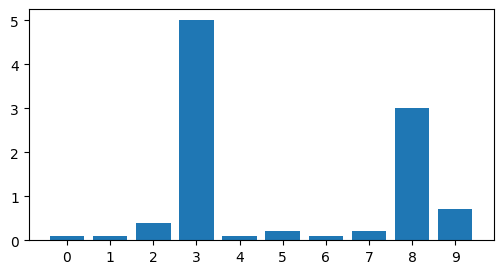

In [ ]:
from matplotlib import pyplot as plt

logits = [0.1, 0.1, 0.4, 5, 0.1, 0.2, 0.1, 0.2, 3, 0.7]

plt.figure(figsize=(6, 3))
plt.bar(range(0, 10), logits)
plt.xticks(range(0, 10))
plt.show()

Самый большой логит у тройки, что верно. Но и у восьмерки он большой, так как эти цифры похожи.


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/distilation_mnist_3.png"  width="200" height="200">


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L08/distilation_mnist_8.png"  width="200" height="200">

То есть логиты содержат дополнительную полезную информацию.


Когда мы превратим их в вероятности, она сохранится.

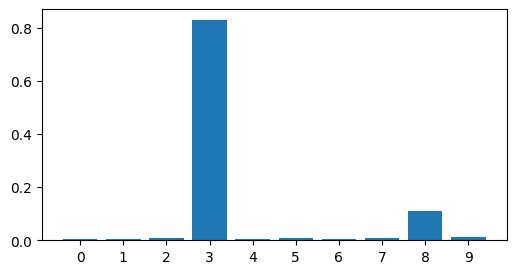

In [ ]:
import torch
from torch.nn.functional import softmax

probs = softmax(torch.tensor(logits), dim=0)

plt.figure(figsize=(6, 3))
plt.bar(range(0, 10), probs)
plt.xticks(range(0, 10))
plt.show()

А вот после того, как мы превратим вектор вероятностей в метку (one_hot вектор), эта дополнительная информация пропадет при округлении.

In [ ]:
one_hot = (probs >= probs.max()).int()
print("One hot ", one_hot)

One hot  tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=torch.int32)


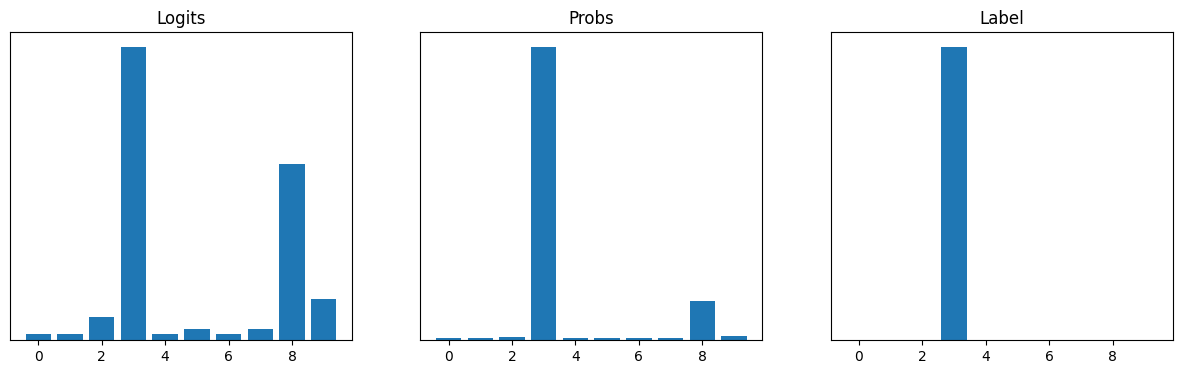

In [ ]:
import numpy as np

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=False)


def bar(ax, y, title):
    x = range(0, 10)
    ax.bar(x, np.array(y))
    ax.set_title(title)
    ax.set_yticks([])


bar(ax1, logits, "Logits")
bar(ax2, probs, "Probs")
bar(ax3, one_hot, "Label")

plt.plot()
plt.show()

Чтобы не терять информацию, можно предсказывать не метку, а весь вектор вероятностей, который получается на выходе большой модели.



[[colab] 🥨 Обучение без использования разметки BYOL](https://colab.research.google.com/drive/13bolgaT23R_l8OcCyhUpeWPdwJEIKqLR?usp=sharing)

<font size="6">Литература</font>

<font size="5">AlexNet:</font>

* [[article] 🎓 ImageNet Classification with Deep Convolutional Neural Networks (Krizhevsky et al., 2012)](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
* [[blog] ✏️ Подробнее про AlexNet](https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide)

<font size="5">ZFNet:</font>

* [[arxiv] 🎓 Visualizing and Understanding Convolutional Networks (Zeiler et al., 2013)](https://arxiv.org/abs/1311.2901)

<font size="5">VGG:</font>

* [[arxiv] 🎓 Very Deep Convolutional Networks for Large-Scale Image Recognition (Simonyan et al., 2014)](https://arxiv.org/abs/1409.1556)
* [[doc] 🛠️ Краткое описание VGGNet](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)

<font size="5">GoogLeNet:</font>

* [[arxiv] 🎓 Going Deeper with Convolutions (Szegedy et al., 2014)](https://arxiv.org/abs/1409.4842)

<font size="5">Global Average Pooling:</font>

* [[arxiv] 🎓 Network In Network, Lin et al., 2013](https://arxiv.org/abs/1312.4400)
* [[blog] ✏️ Max Pooling and Global Average Pooling](https://github.com/christianversloot/machine-learning-articles/blob/main/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling.md)
* [[arxiv] 🎓 Global Pooling, More than Meets the Eye: Position Information is Encoded Channel-Wise in CNNs (Islam et al., 2021)](https://arxiv.org/abs/2108.07884)

<font size="5">ResNet:</font>

* [[arxiv] 🎓 Deep Residual Learning for Image Recognition (He et al., 2015)](https://arxiv.org/abs/1512.03385)

<font size="5">Fixup Initialization:</font>

* [[arxiv] 🎓 Fixup Initialization: Residual Learning Without Normalization (Zhang et. al, 2019)](https://arxiv.org/abs/1901.09321)

<font size="5">ResNeXt:</font>

* [[arxiv] 🎓 Aggregated Residual Transformations for Deep Neural Networks (Xie et al., 2016)](https://arxiv.org/abs/1611.05431)
* [[blog] ✏️ Review of ResNet Family: from ResNet to ResNeSt](https://sheng-fang.github.io/2020-05-20-review-resnet-family/)

<font size="5">DenseNet:</font>

* [[arxiv] 🎓 Densely Connected Convolutional Networks (Huang et al., 2016)](https://arxiv.org/abs/1608.06993)

<font size="5">WideResNet:</font>

* [[arxiv] 🎓 Wide Residual Networks (Zagoruyko et al., 2016)](https://arxiv.org/abs/1605.07146)

<font size="5">SENet:</font>

* [[arxiv] 🎓 Squeeze-and-Excitation Networks (Hu et al., 2017)](https://arxiv.org/abs/1709.01507)
* [[blog] ✏️ Squeeze and Excite Networks: A Performance Upgrade](https://viso.ai/deep-learning/squeeze-and-excite-networks/)

<font size="5">MobileNet:</font>

* [[arxiv] 🎓 MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications (Howard et al., 2017)](https://arxiv.org/abs/1704.04861)

<font size="5">EfficientNet:</font>

* [[arxiv] 🎓 EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks (Tan et al., 2019)](https://arxiv.org/abs/1905.11946)

<font size="5">Visual Transformer:</font>

* [[arxiv] 🎓 Visual Transformers: Token-based Image Representation and Processing for Computer Vision (Wu et al., 2020)](https://arxiv.org/abs/2006.03677)
* [[blog] ✏️ Разбор ViT](https://viso.ai/deep-learning/vision-transformer-vit/)
* [[arxiv] 🎓 An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (Dosovitskiy et al., 2020)](https://arxiv.org/abs/2010.11929)

<font size="5">Дополнительно:</font>
* [[blog] ✏️  A Tutorial on Filter Groups (Grouped Convolution)](https://blog.yani.ai/filter-group-tutorial/)
* [[arxiv] 🎓 Benchmark Analysis of Representative Deep Neural Network Architectures (Bianco et al., 2018)](https://arxiv.org/abs/1810.00736)
* [[arxiv] 🎓 Neural Architecture Search with Reinforcement Learning (Zoph et al., 2016)](https://arxiv.org/abs/1611.01578)